Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC2433 - Minería de Datos
<br>

<center>
    <h2> Tarea 1 </h2>
    <h1> K-Means </h1>
    <p>
        Profesor Marcelo Mendoza<br>
        Primer Semestre 2023<br>    
        Fecha de entrega: Viernes 31 de Marzo
    </p>
    <br>
</center>

<br>

---

## Indicaciones

Deberás entregar **SOLO** el archivo .ipynb en el buzón respectivo en canvas. 

**IMPORTANTE**: 
- Se te dará puntaje tanto por código como por la manera en la que respondas las preguntas planteadas. Es decir, si tienes un código perfecto pero este no es explicado o no se responden preguntas asociadas a este, no se tendrá el puntaje completo.
- El notebook debe tener todas las celdas de código ejecutadas. Cualquier notebook que no las tenga no podrá ser corregido.
- El carácter de esta tarea es **INDIVIDUAL**. Cualquier instancia de copia resultará en un 1,1 como nota de curso.

---

## Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score, accuracy_score
from sklearn import preprocessing

from matplotlib import offsetbox
from sklearn.manifold import TSNE

from sklearn.manifold import MDS

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm


## Parte 1: Carga y Preprocesamiento de Datos (12 pts.)

### 1.1 Carga de Datos

Para esta tarea deberás trabajar con el dataset de Scikit Learn [digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits).

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

### 1.2 Descripción del dataset (2 pt.)

¿Qué representa el dataset? Menciona que es lo describe el dataset en general 

Representa un número de dígitos del 0 al 9 escritos a mano por 43 personas, representados en una imagen de 8x8 pixeles, coloreados en una escala de grises indexados del 0 al 16. Creados por UCI

### 1.3 Limpieza del set de datos (4 pts.)

Ahora debes limpiar el set de datos. Para esto determina y justifica que harás con los valores nulos, los outliers, las columnas y filas incompletas, y las características que consideres perjudiciales para el manejo de datos.

In [3]:
# tamaño
print(f'Tamaño:{digits.data.shape}')
# numero de nulos
print(f'Número de nulos: {X[~np.isnan(X)].shape - np.array(64*1797)}')

Tamaño:(1797, 64)
Número de nulos: [0]


Esto muestra que no hay nulos. Notamos que por la naturaleza del dataset no hay outliers (rango acotado) y además no hay filas ni columnas incompletas

### 1.4 Normalización de datos (6 pts.)

Normaliza las columnas del set de datos que consideres necesarias, justifica tus decisiones y explica por qué es útil realizar esta acción. (2pts)

Usare, dado el rango de grises una normalización min max, ya que me parece la más natural, no tiene sesgos y entrega un intervalo [0,1]

In [4]:
X = preprocessing.MinMaxScaler().fit_transform(X)

Esto es útil ya que restringe los datos a un intervalo conocido y cómodo, sin dejar de representar la distribución de los valores

Menciona los principales beneficios de trabajar con columnas que posean valores normalizados. (1 pt.)

Los beneficios incluyen que representa la relación de los datos con sus extremos mínimo y máximo, de forma que puedan ser interpretados como porcentajes. Además, el intervalo 0-1 es estándar en muchas aplicaciones matemáticas y facilita la representacion de los datos en diagramas o gráficos.

## Parte 2: PCA, t-SNE y MDS (16 pts.)

### 2.1 PCA

En esta parte deberás construir 2 PCA

1. PCA debe retener un 95% de la varianza de los datos originales.
2. PCA debe construirse con dimensionalidad n=2

Para el primer caso deberás graficar como aumenta el porcentaje de varianza retenida a medida que aumenta el número de componentes.

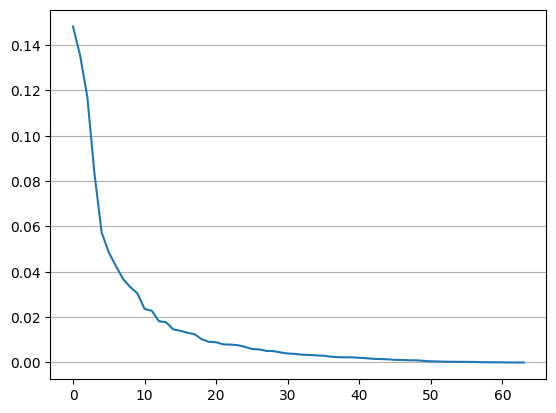

In [5]:
# Visualización de varianza
pca = PCA().fit(X)
plt.plot(pca.explained_variance_ratio_)
plt.grid(axis='y')

# Funcion de numero de componentes
def min_var(v,exp_var):
    acc = 0
    i=0
    while acc < v:
        acc += exp_var[i]
        i += 1
    return i

#### PCA 95% (4 pts.)

In [13]:
# crear numero 95%
num_95 = min_var(.95,pca.explained_variance_ratio_)
print(num_95)

# fit PCA
pca95_model = PCA(num_95).fit(X)
pca95 = PCA(num_95).fit_transform(X)

30


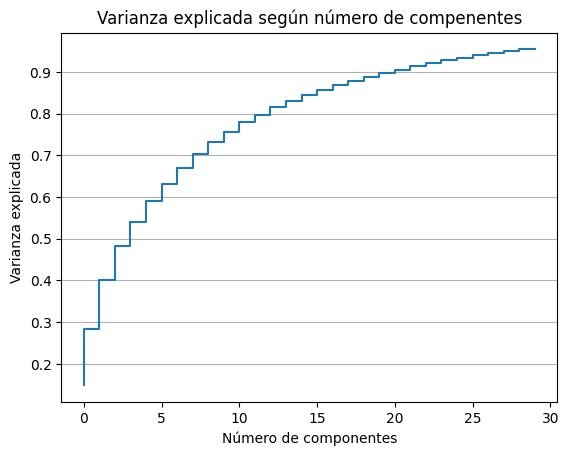

In [14]:
# varianza acomulada
cum_var_pca95 = np.cumsum(pca95_model.explained_variance_ratio_)

# gráfico 
plt.step(range(0,num_95), cum_var_pca95)
plt.ylabel('Varianza explicada')
plt.xlabel('Número de componentes')
plt.grid(axis='y')
plt.title('Varianza explicada según número de compenentes')
plt.show()

#### PCA dimensionalidad n=2 (4 pts.)

In [15]:
pca2 = PCA(2).fit_transform(X)

### 2.2 t-SNE (4 pts.)

Para esta sección se espera que grafiques t-SNE con 2 componentes. Una vez obtenido el gráfico, analiza que números serán más probables que sean mal clasificados. Justifica la elección del parámetro perplexity.

In [16]:
def plot_embedding(X, title):
    _, ax = plt.subplots(figsize=(8, 8))
    X = preprocessing.MinMaxScaler().fit_transform(X)

    for digit in digits.target_names:
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            color=plt.cm.Dark2(digit),
            alpha=0.425, # The alpha blending value, between 0 (transparent) and 1 (opaque)
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i] 
        ) # Container referring to a specific position xy defined by X[i]
        imagebox.set()
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


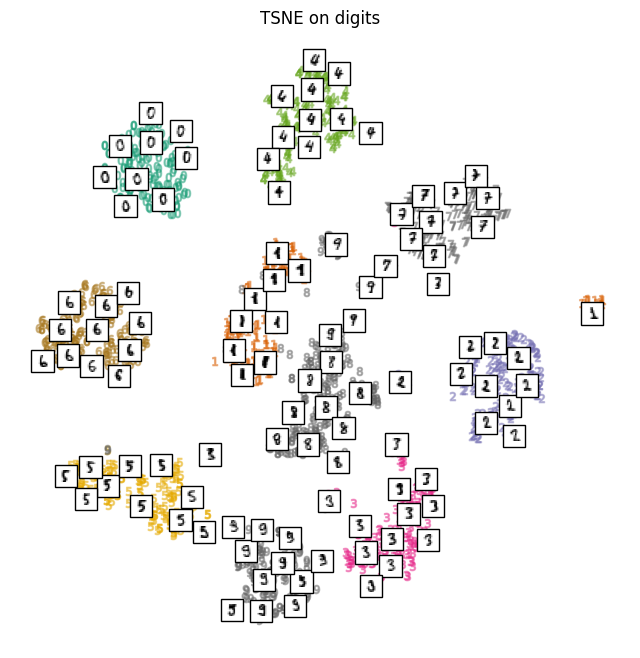

In [33]:
tsne_embed = TSNE(n_components=2, perplexity = 20, n_iter=500, n_iter_without_progress=150, n_jobs=10, random_state = 1) 
# consideramos perpexity 20 pues no es una base de datos 
# que requiera valores mayores, por sis dimenciones
projection_tnse = tsne_embed.fit_transform(X, y)
plot_embedding(projection_tnse, 'TSNE on digits')
plt.show()

Notamos que los números forman clusters relativamente bien definidos, y en dígitos como 2, 4,6 lso clusters son muy acotados y no se mezclan (casi) con otros dígitos. Esto nos hace pensar que son difíciles de clasificar de forma incorrecta.

Los números 0, 3, 5, 7, 8 tambien tienen una distribución espacial acotada pero tienen elementos cercanos a otros clusters, a veces llegando a tener elementos cruzados. Esto implica que tienen cierta probabilidad de ser mal calsificados con otros dígitos con clusters cercanos.

Finalmente 1, 9 tienen un comportamiento errático pues tienen elementos muy lejanos a sus clusters principales, además de tenes incluso más de un cluster. Esto implica que serían clasificados incorrectamente con alta probabilidad.

### 2.3 MDS (4 pts.)

Para esta sección se espera que grafiques MDS con 2 componentes. Una vez obtenido el gráfico, analiza que números serán más probables que sean mal clasificados.

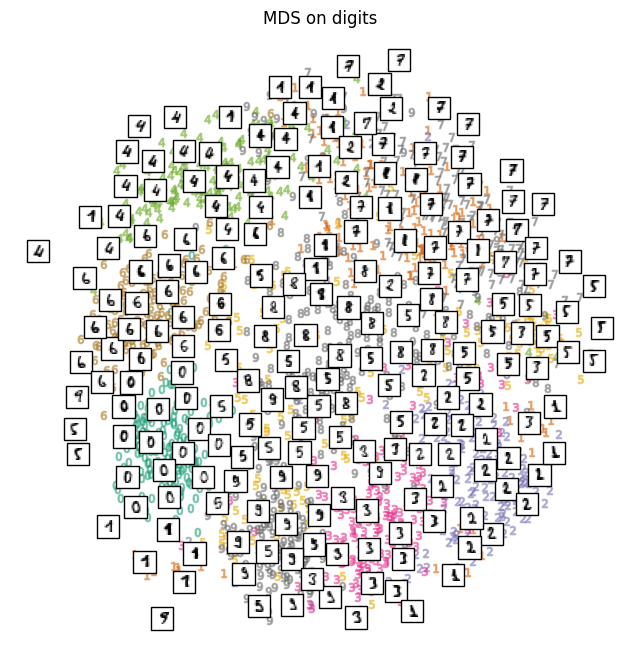

In [34]:

mds_embed = MDS(n_components=2, max_iter=500, n_jobs=10, random_state=1)
projection_mds = mds_embed.fit_transform(X, y)
plot_embedding(projection_mds, 'MDS on digits')
plt.show()

Los dígitos 0, 4, 6, 8 se mantienen realtivamente acotados y cercanos al centro del cluster, con lo que deberían ser dificil de confundir. Los números 2, 3 también son relativamente bien comportados , pero un poco menos que los anteriores. Finalmente los dígitos 7 y 1 se ven muy mezclados con lo que deben ser confundidos regularmente. Por otro lado el dígito 5 esta en todos lados, con lo que debe ser difícil de identificar. Finalmente el digito 9 se mantiene relativamente acotado pero tiene alta interseccion con otros digitos con lo que debe tener una cierta probabilidad de ser identificado de forma errónea.

## Parte 3: K-Means (20 pts.)

En esta sección debes trabajar con los 4 modelos obtenidos en la sección anterior (PCA (n=2), PCA (95% varianza), t-SNE y MDS), en donde por cada modelo deberas:

* Correr K-Means para valores k en el rango [5, 6, 7, 8, 9, 10] **(0.5 pts)**
* Realizar un gráfico ELBOW **(2 pts)**
* Obtener el Silhoutte Score para distintos números de cluster y graficar **(1.5 pt.)** 
* Determinar el número de clusters óptimo **(0.5 pts)**
* Obtener el accuracy de cada dataset (utilizar `digits['target']`) **(0.5 pts.)**

Para poder realizar el gráfico ELBOW deberás utilizar el atributo `inertia_` de [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans). Mientras que para obterner el accuracy deberas ocupar la métrica [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) del módulo `metrics` de Scikit Learn.

Nota: Son 4 puntos por modelo, y los puntos se distribuyen como se muestra arriba

## Funciones y parámetros

In [22]:
# parametros
k_values = [5,6,7,8,9,10]

In [23]:
# funcion grafico elbow
def elbow_plot(k_values, model):
    # inertia vector
    mean_intertia = []
    for k in k_values:
        km = KMeans(init = 'random', n_clusters = k, n_init = 4)
        km.fit(model)
        mean_intertia.append(km.inertia_/k)
    # inertia plot
    plt.plot(k_values, mean_intertia, color = 'steelblue')
    plt.grid()
    plt.xlabel('number of clusters')
    plt.ylabel('Mean SSE')
    plt.title('Mean SSE by number of clusters')
    plt.show()
    
# funcion graficar silluette
def graficar_silluette(k_values, model):
    for k in k_values:
        # modelos
        km = KMeans(init = 'random', n_clusters = k, n_init = 4)
        mod = km.fit(model)
        # silluette score
        cluster_labels = mod.fit_predict(model)
        # grafico
        fig, ax = plt.subplots(figsize = (6,12))
        ax.set_xlim([-1, 1])
        ax.set_ylim([0,len(model)+10*(k+1)])
        # silluette score
        silhouette_avg = silhouette_score(model, cluster_labels)
        print(
            "For n_clusters =",
            k,
            "The average silhouette_score is :",
            silhouette_avg,
        )
        sample_silhouette_values = silhouette_samples(model, cluster_labels)
        # graficos
        y_lower = 10
        for i in range(k):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]  
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / k)
            ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10

            ax.set_title("Silhouette plot")
            ax.set_xlabel("The silhouette coefficient values")
            ax.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
            ax.axvline(x=silhouette_avg, color="red", linestyle="--")

            ax.set_yticks([])  # Clear the yaxis labels / ticks
            ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % k,
            fontsize=14,
            fontweight="bold",
            )

    plt.show()

# funcion kmeans
def modelos_kmeans(k_values, model):
    out = []
    for k in k_values:
        # modelos
        km = KMeans(init = 'random', n_clusters = k, n_init = 4)
        mod = km.fit(model)
        # silluette score
        cluster_labels = mod.fit_predict(model)
        out.append([km,mod,cluster_labels])
    return out

## PCA 2

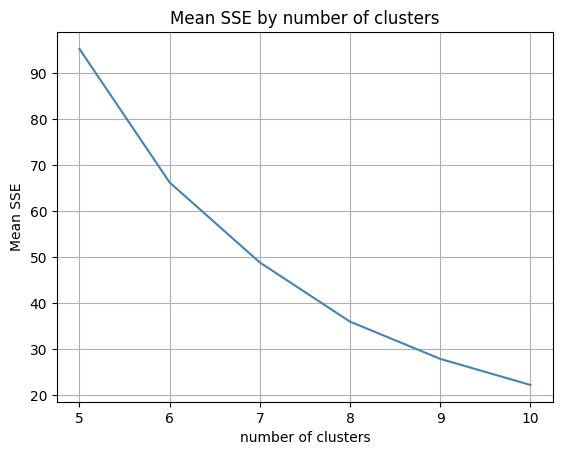

For n_clusters = 5 The average silhouette_score is : 0.3951728281723502
For n_clusters = 6 The average silhouette_score is : 0.4046209837039763
For n_clusters = 7 The average silhouette_score is : 0.4032800129168165
For n_clusters = 8 The average silhouette_score is : 0.39112339470219054
For n_clusters = 9 The average silhouette_score is : 0.4025784307217623
For n_clusters = 10 The average silhouette_score is : 0.39610541687390316


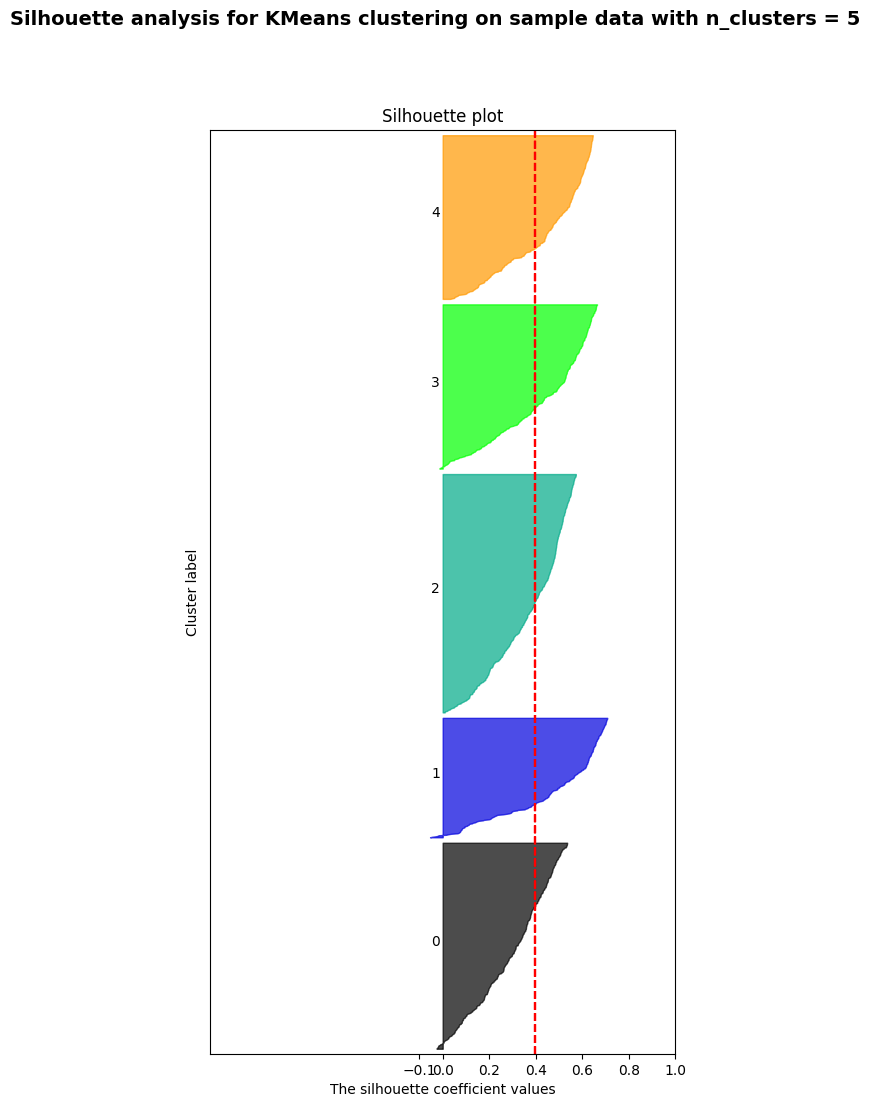

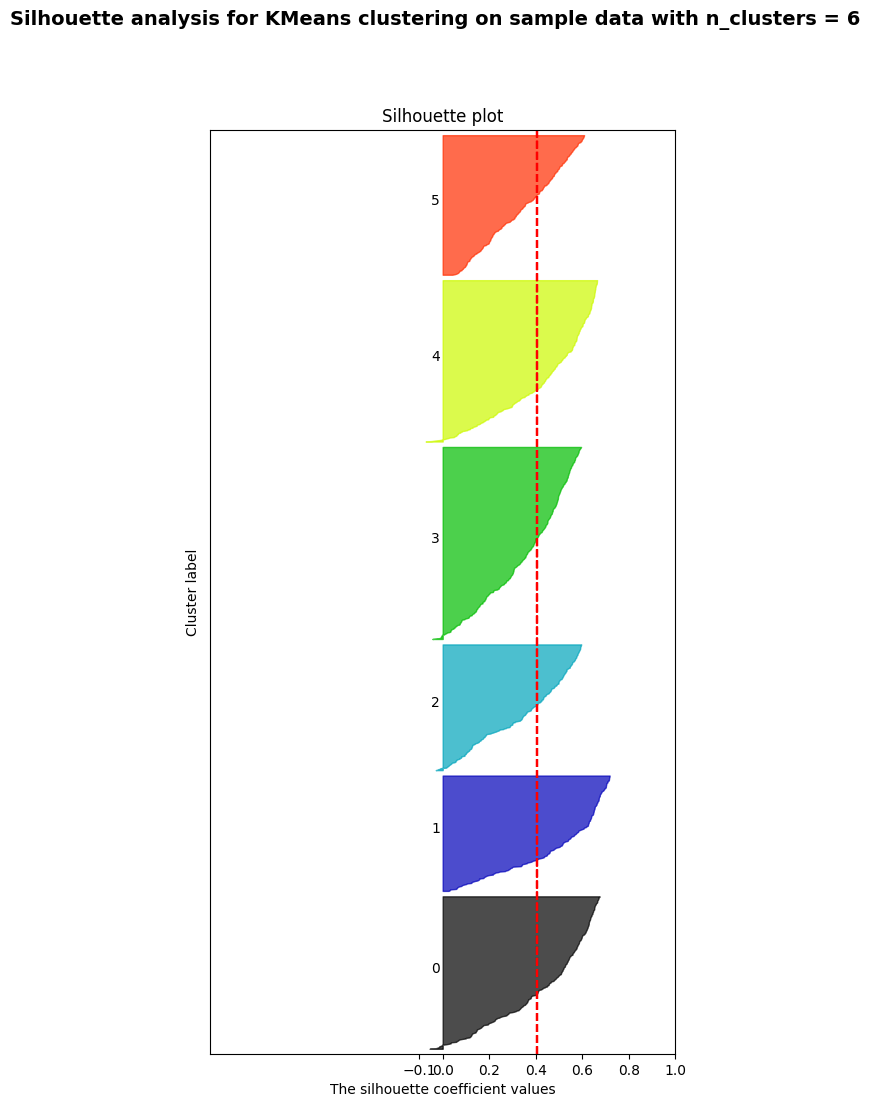

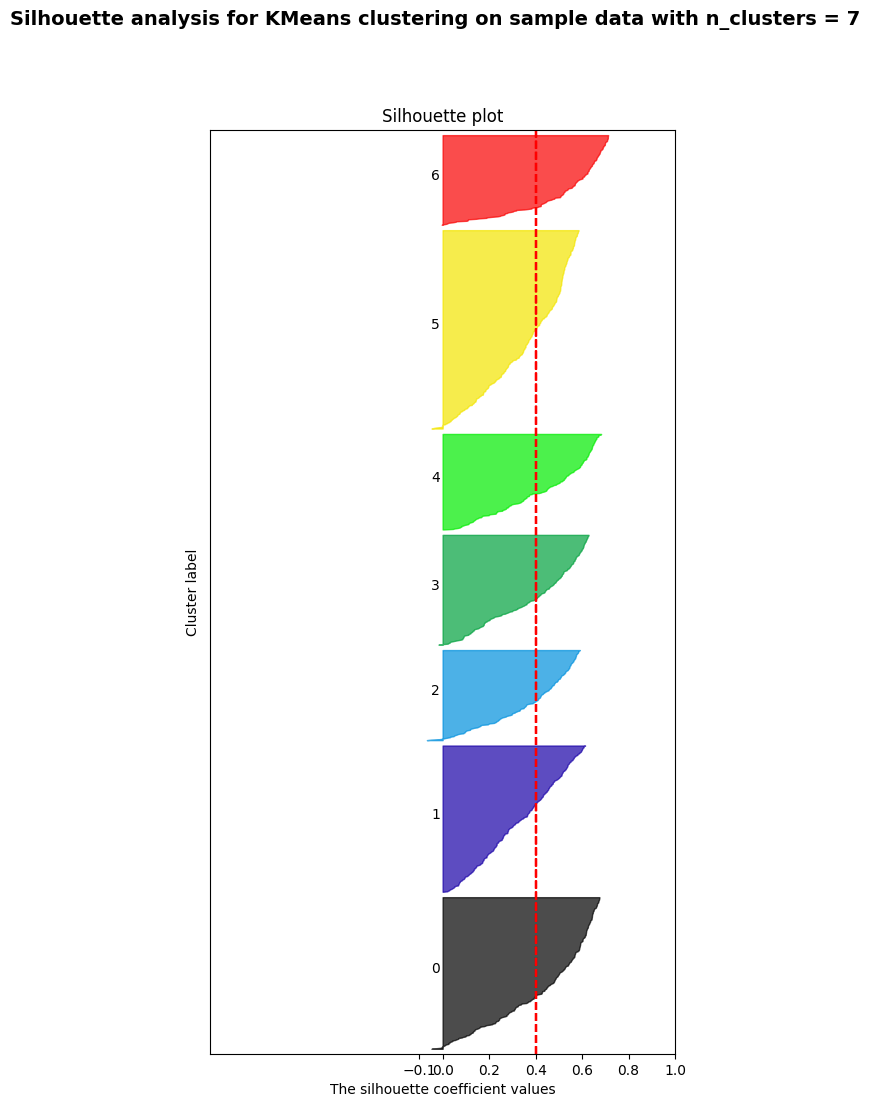

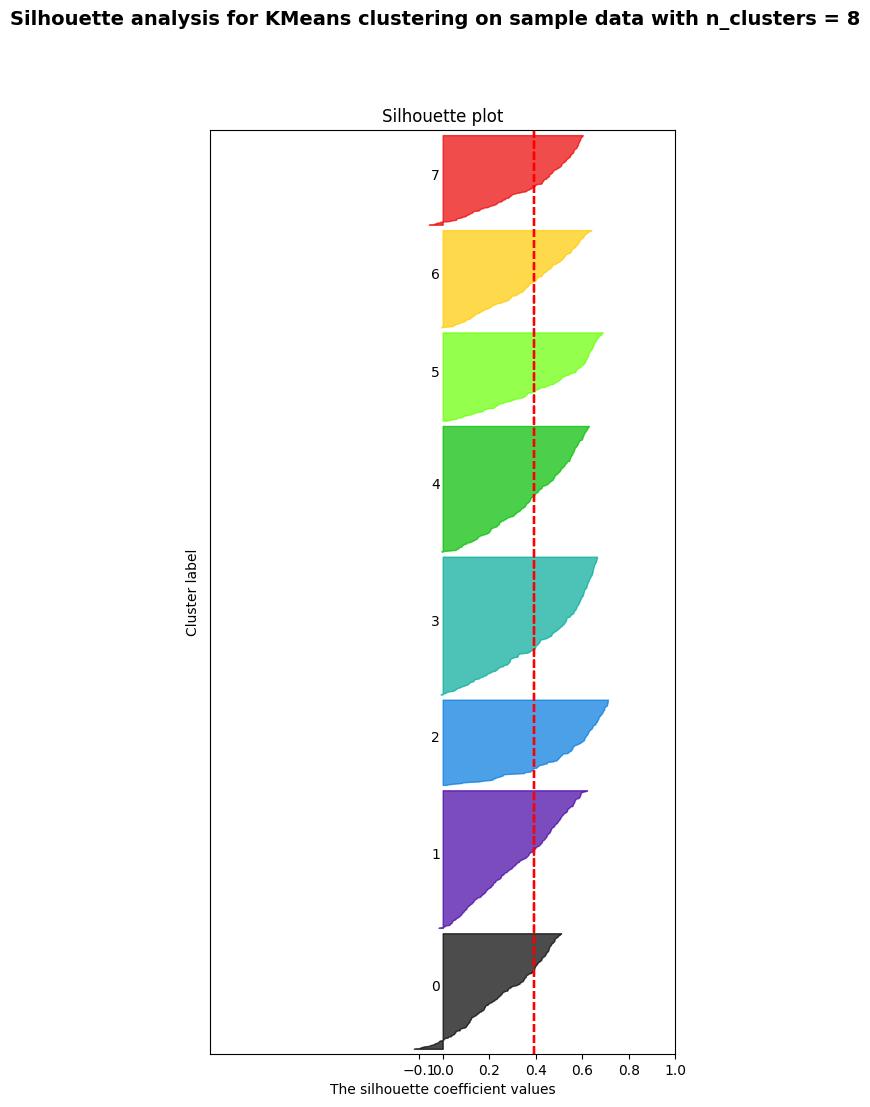

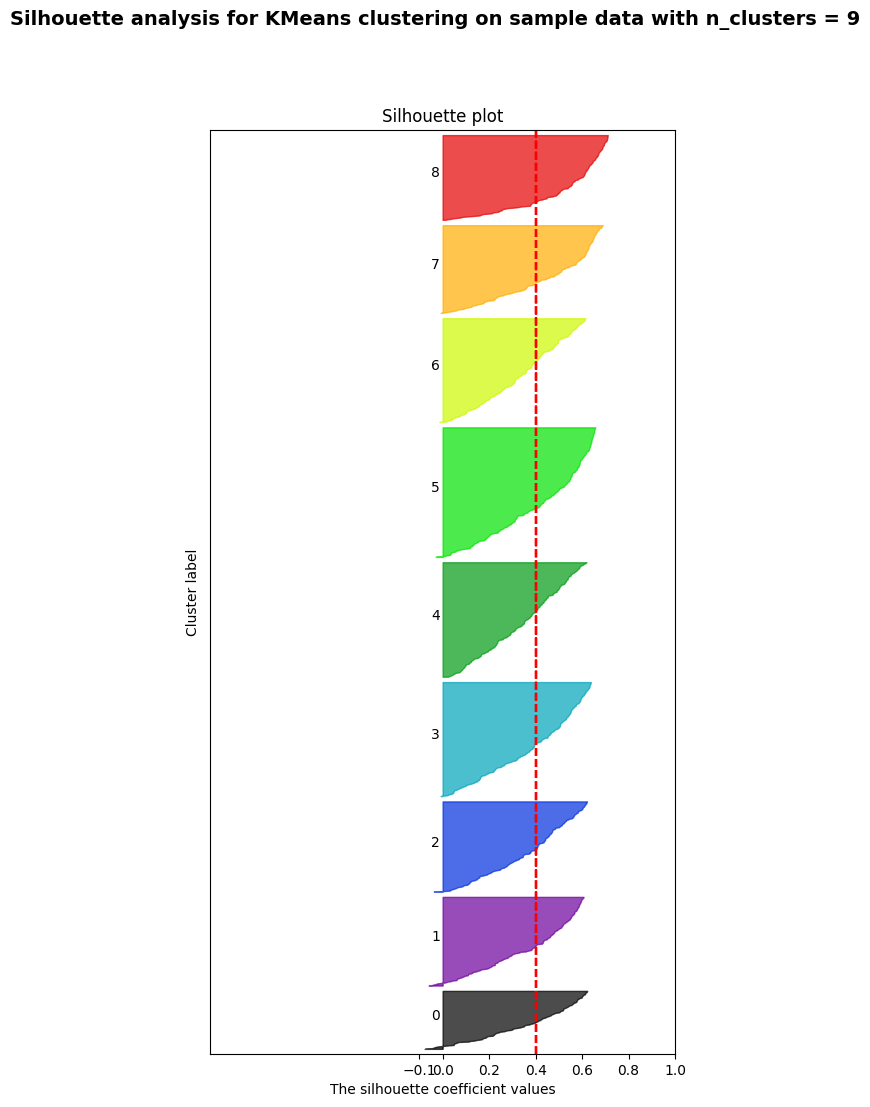

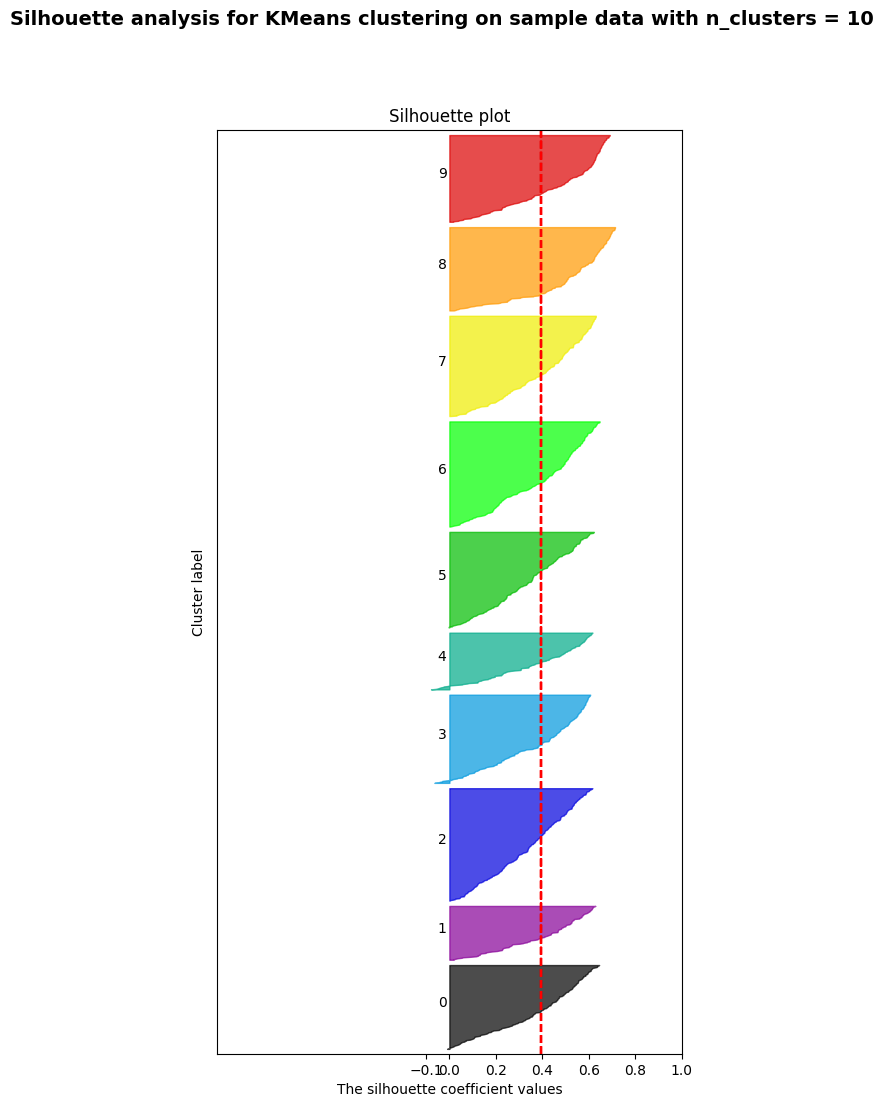

In [24]:
kmeans_pca2 = modelos_kmeans(k_values, pca2)
elbow_plot(k_values, pca2)
graficar_silluette(k_values, pca2)

En cuanto al gráfico elbow notamos que el óptimo es 7 u 8, mientras que el silluette score indica que es 6 o 7. viendo el grafico de silluette vemos que k = 7 tambien se ve mejor con lo que el óptimo es $k = 7$

In [35]:
accuracy_score(
    y,KMeans(init='random', n_clusters=7,n_init=4).fit_predict(pca2)
)

0.04897050639955482

## PCA95

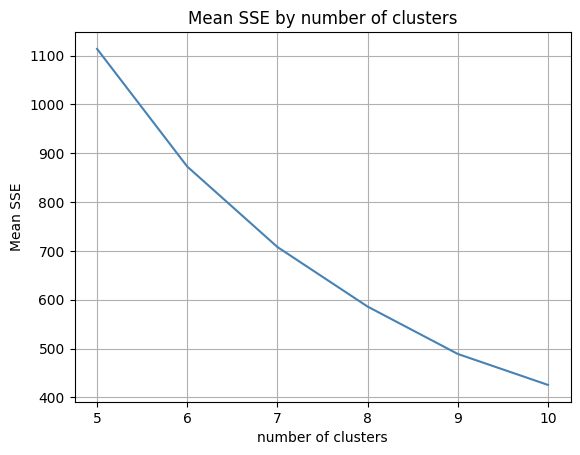

For n_clusters = 5 The average silhouette_score is : 0.14412924202925853
For n_clusters = 6 The average silhouette_score is : 0.15494343319344686
For n_clusters = 7 The average silhouette_score is : 0.173474079285389
For n_clusters = 8 The average silhouette_score is : 0.18701244051046756
For n_clusters = 9 The average silhouette_score is : 0.20094137459546385
For n_clusters = 10 The average silhouette_score is : 0.19393595034419883


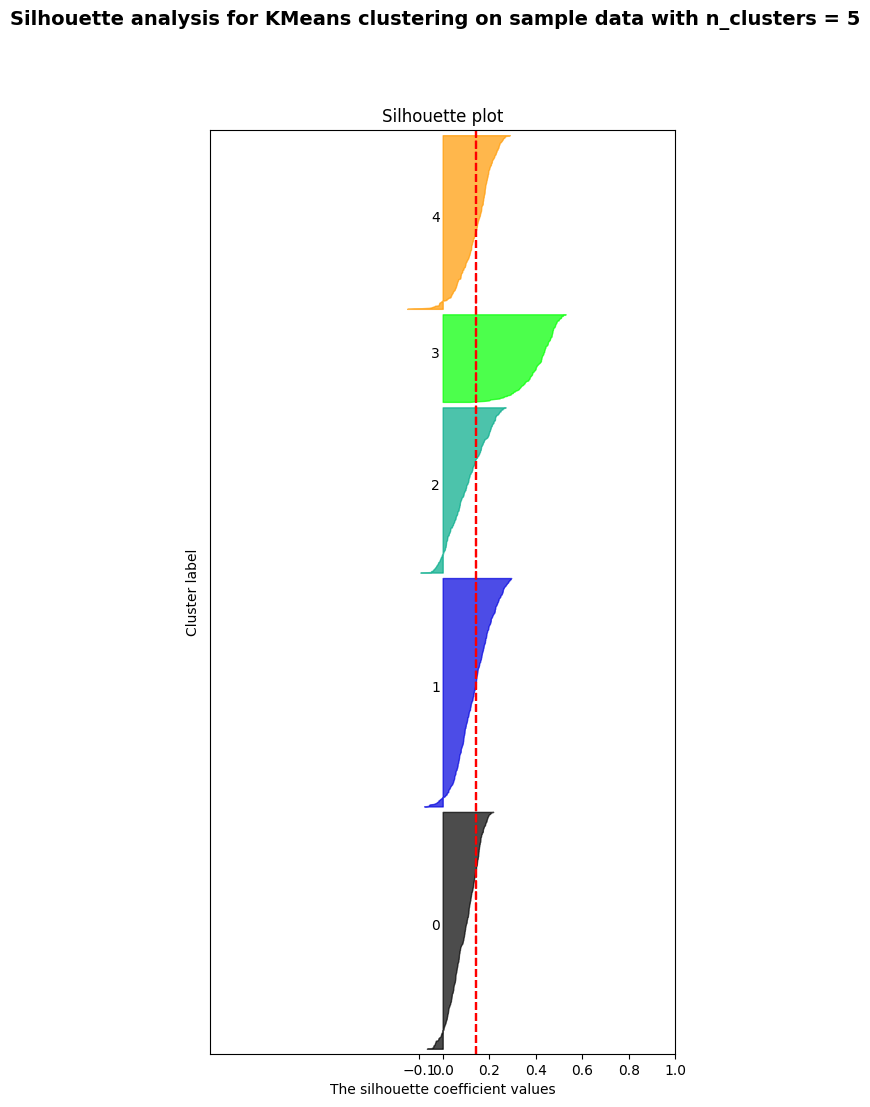

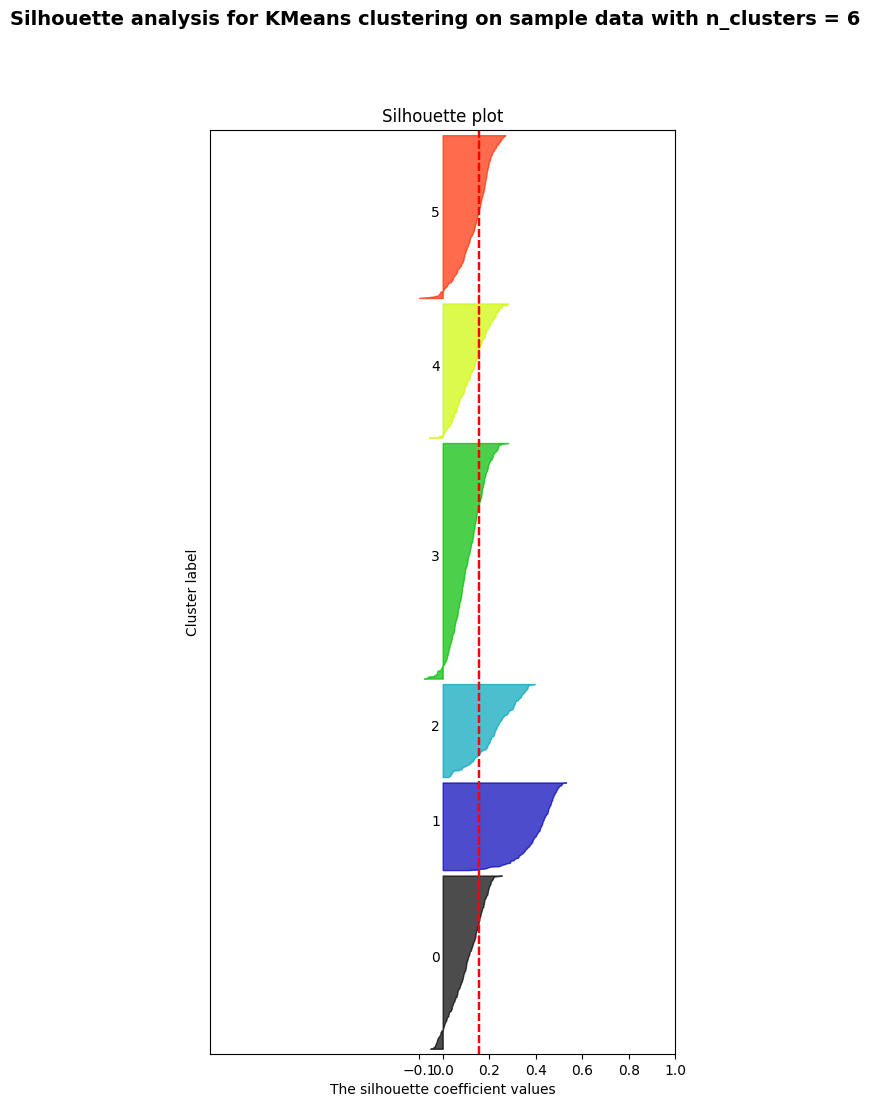

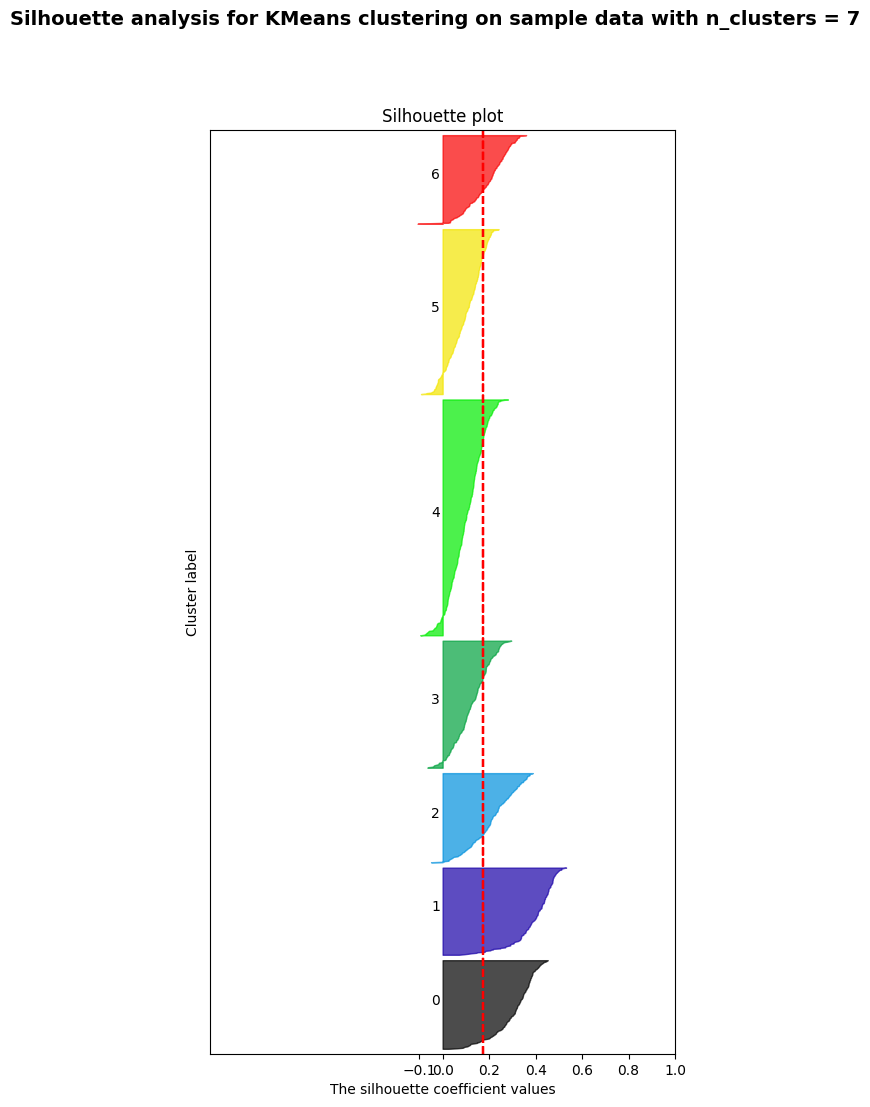

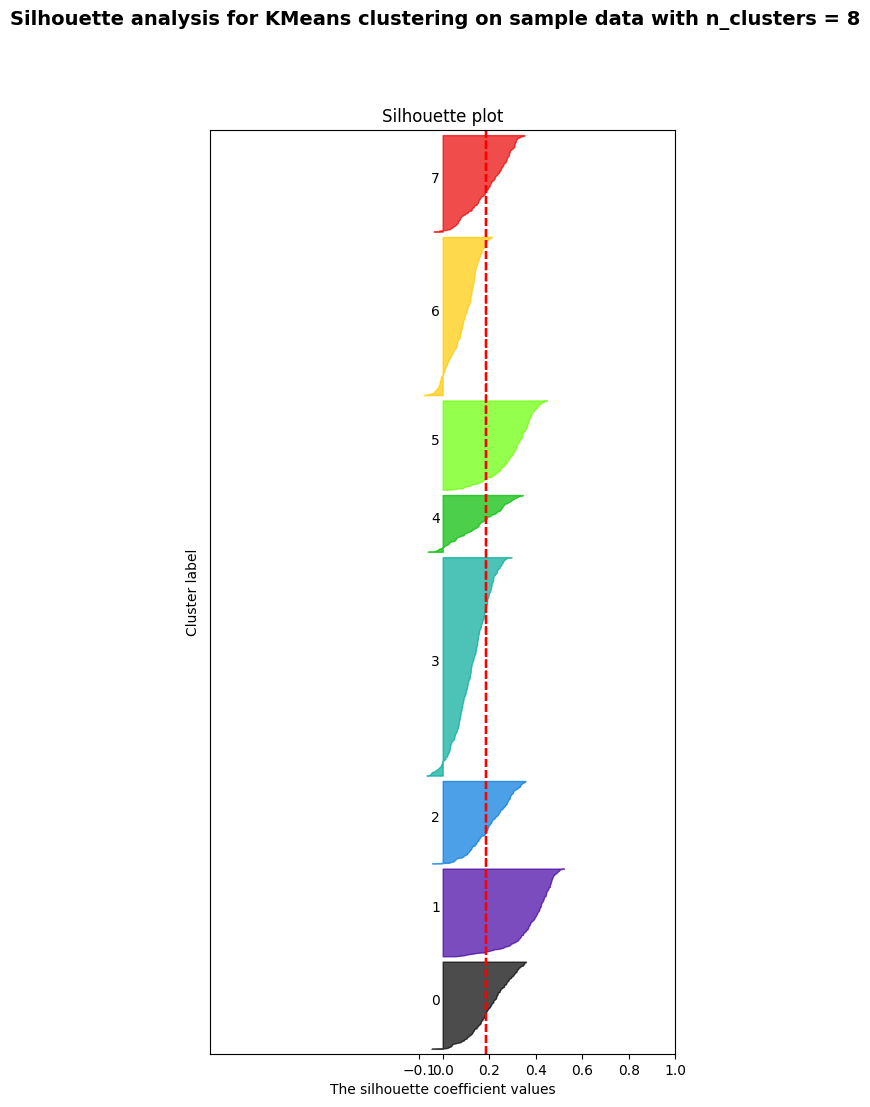

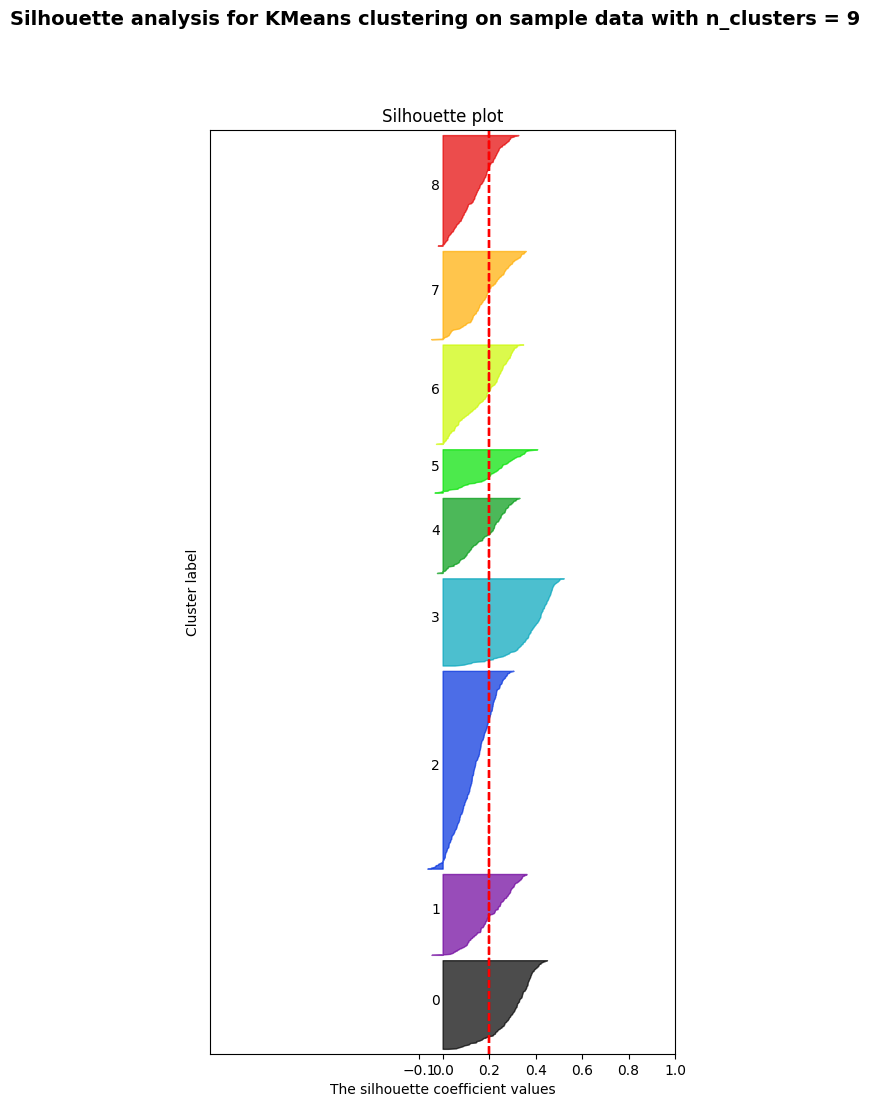

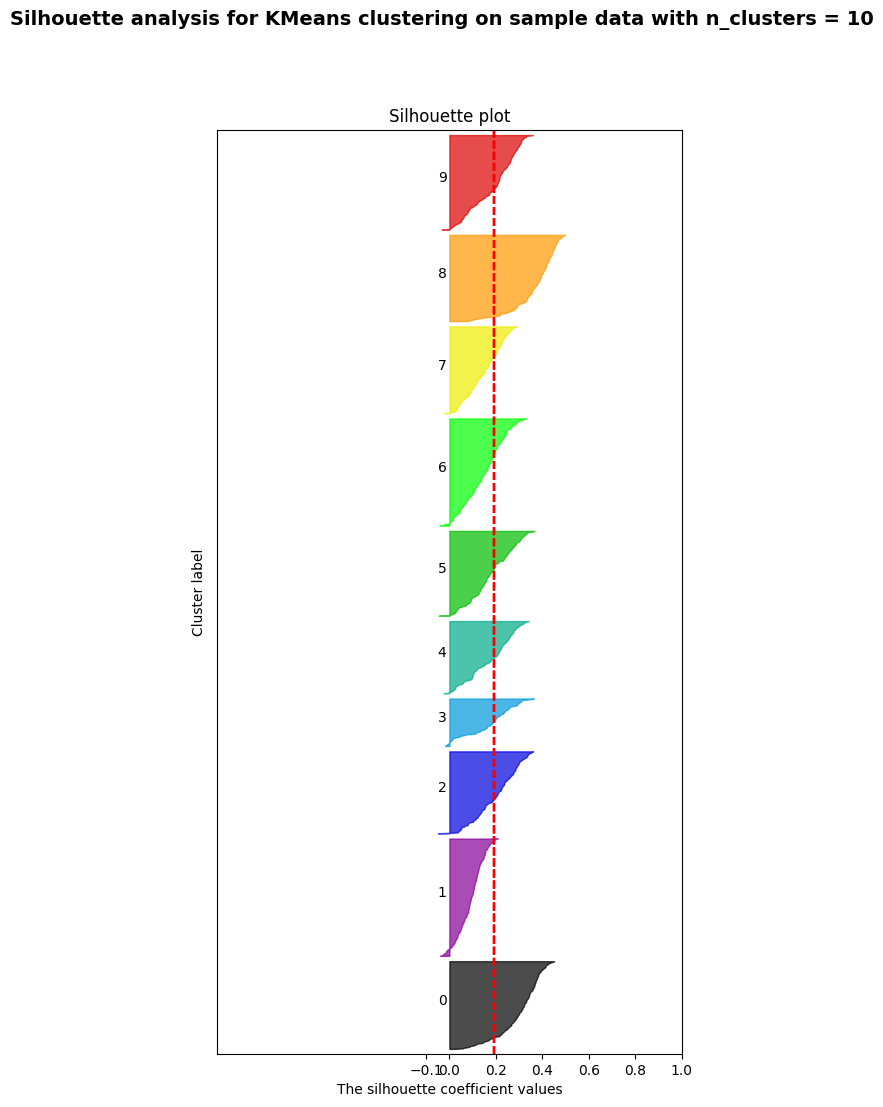

In [36]:
kmeans_pca95 = modelos_kmeans(k_values, pca95)
elbow_plot(k_values, pca95)
graficar_silluette(k_values, pca95)

Notamos automáticamente por los silluette socre promedio y los graficos, ademas del gráfico ELBOW que el $k = 9$ es el óptimo (ELBOW y silluette score coinciden evidentemente)

In [37]:
accuracy_score(
    y,KMeans(init='random', n_clusters=9,n_init=4).fit_predict(pca95)
)

0.17807456872565386

## TNSE

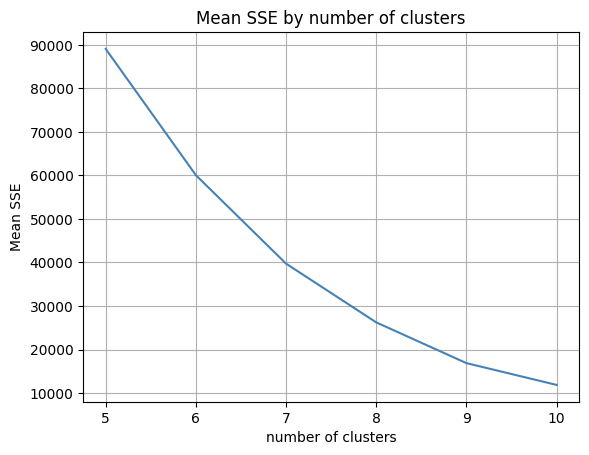

For n_clusters = 5 The average silhouette_score is : 0.40949088
For n_clusters = 6 The average silhouette_score is : 0.46512312
For n_clusters = 7 The average silhouette_score is : 0.5128398
For n_clusters = 8 The average silhouette_score is : 0.5597281
For n_clusters = 9 The average silhouette_score is : 0.5753224
For n_clusters = 10 The average silhouette_score is : 0.5892686


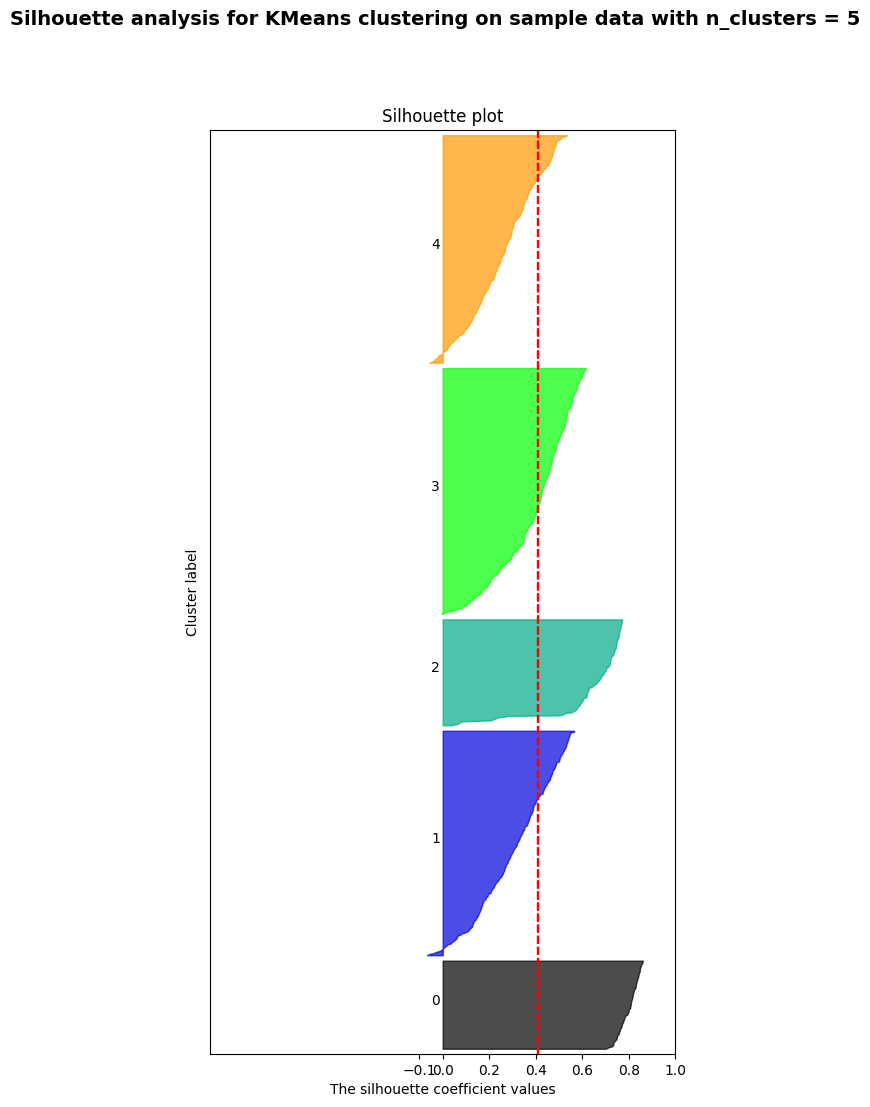

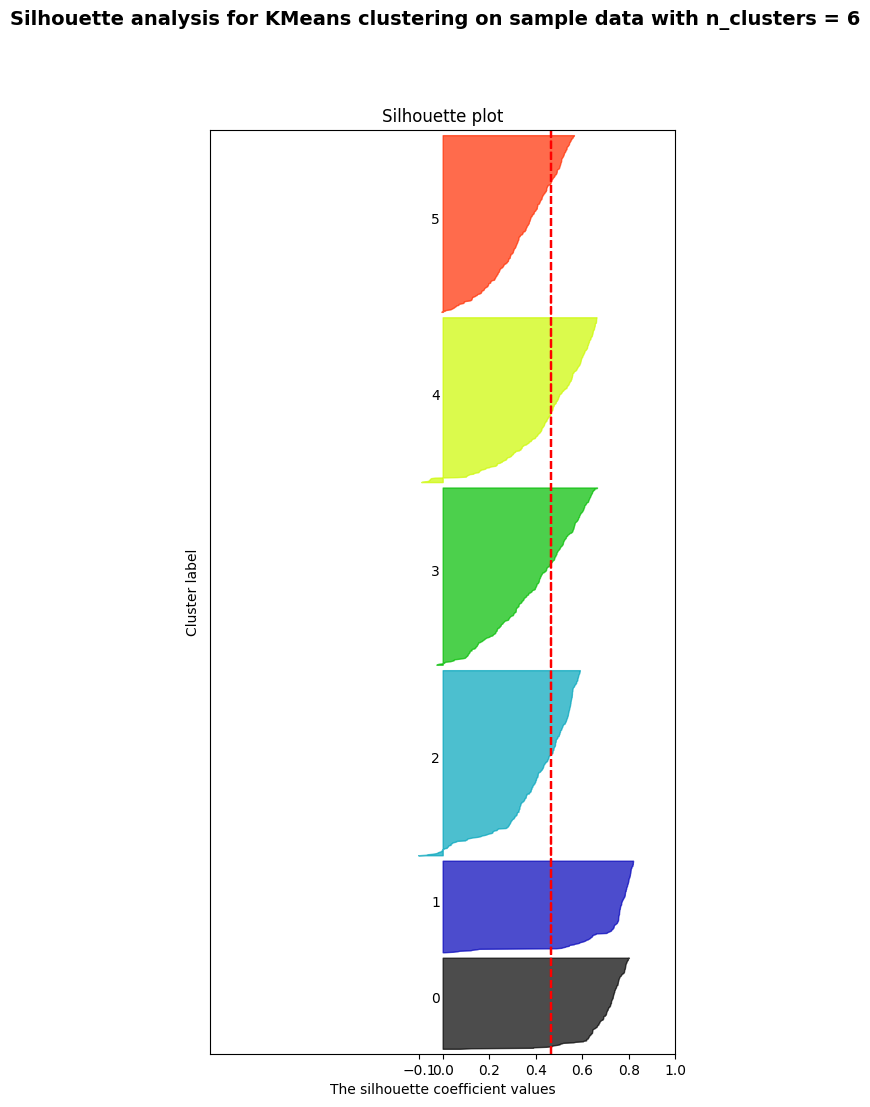

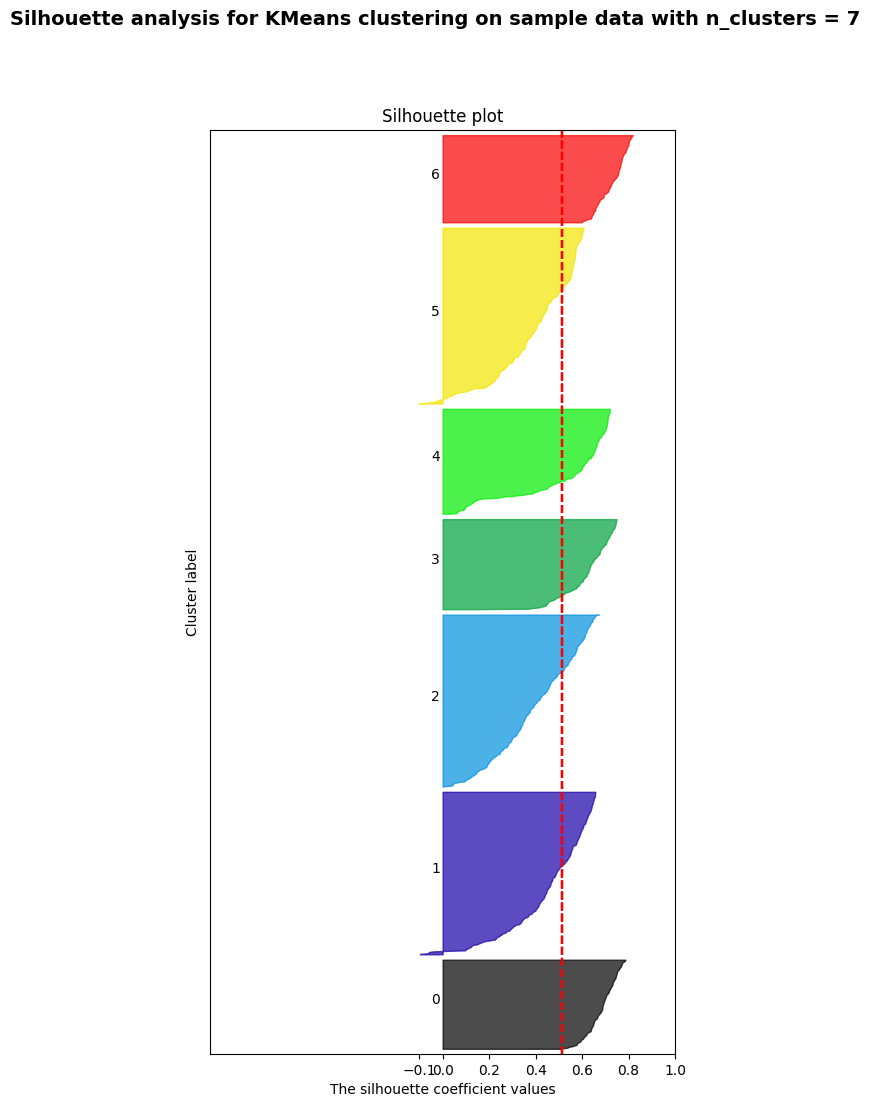

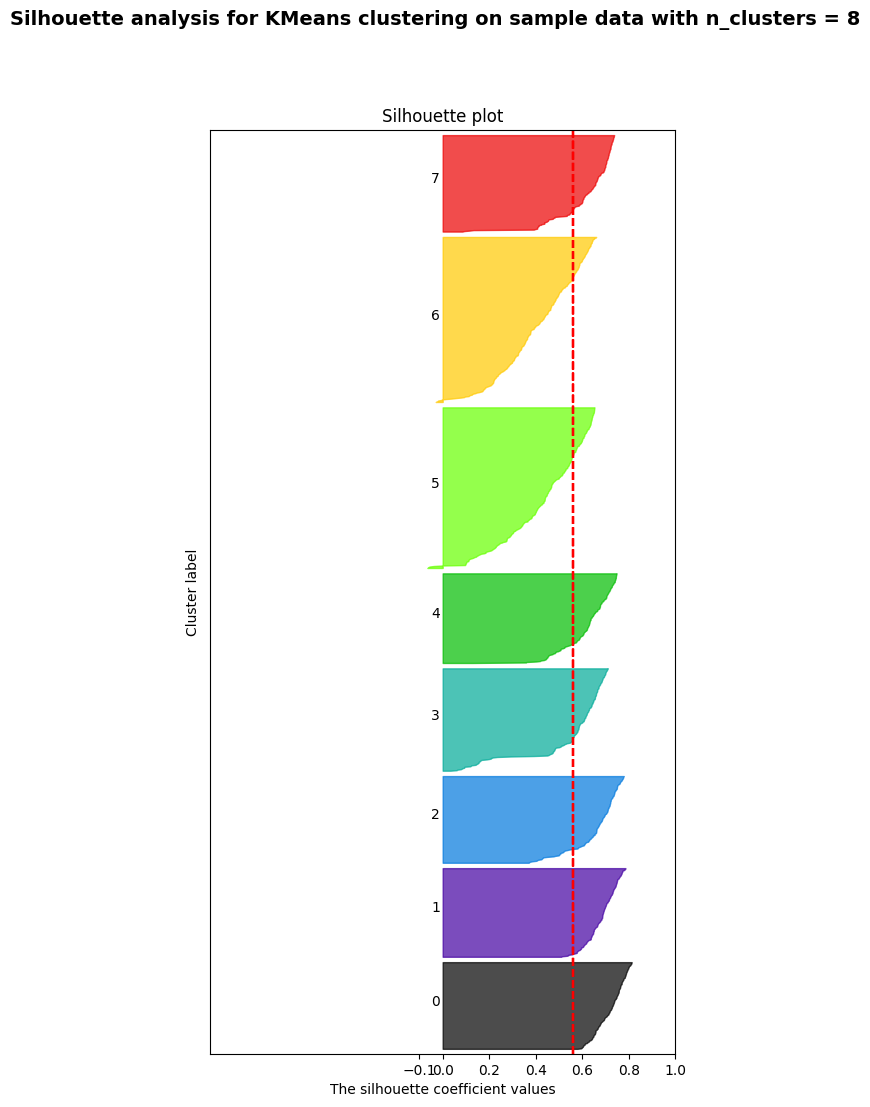

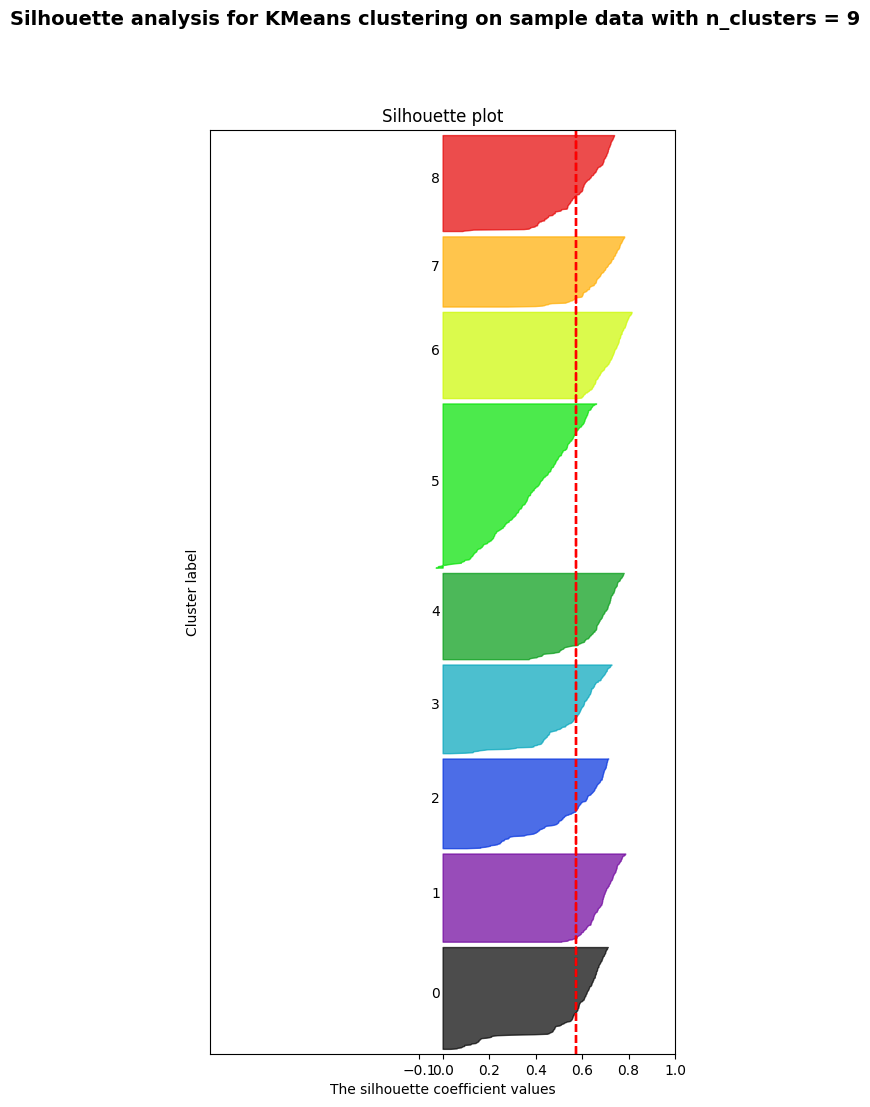

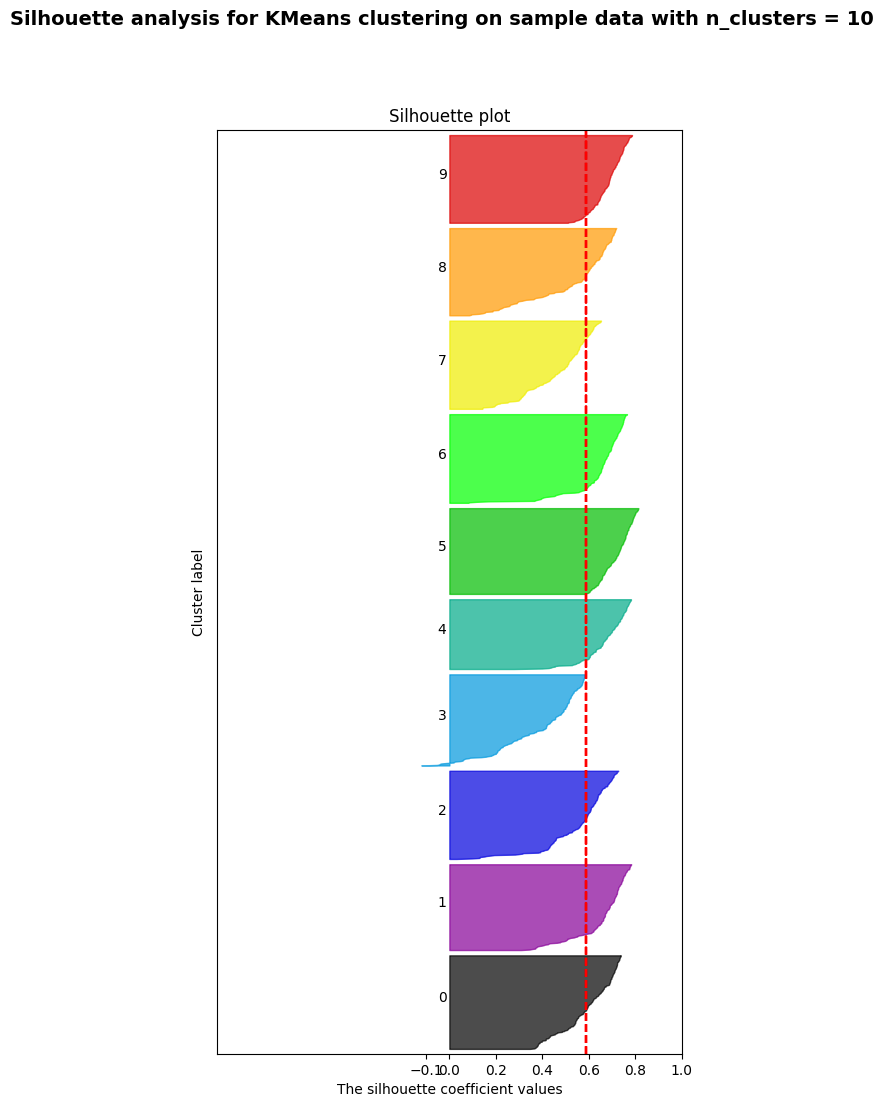

In [38]:
kmeans_tnse = modelos_kmeans(k_values, projection_tnse)
elbow_plot(k_values, projection_tnse)
graficar_silluette(k_values, projection_tnse)

El gráfico ELBOW nos indica que es 9. El silluette score es mejor para $k=10$ pero por una diferencia pequeña. El gráfico silluette tambien nos indica que $k=9$ es el óptimo.

In [39]:
accuracy_score(
    y,KMeans(init='random', n_clusters=9,n_init=4).fit_predict(projection_tnse)
)

0.10127991096271564

## MDS

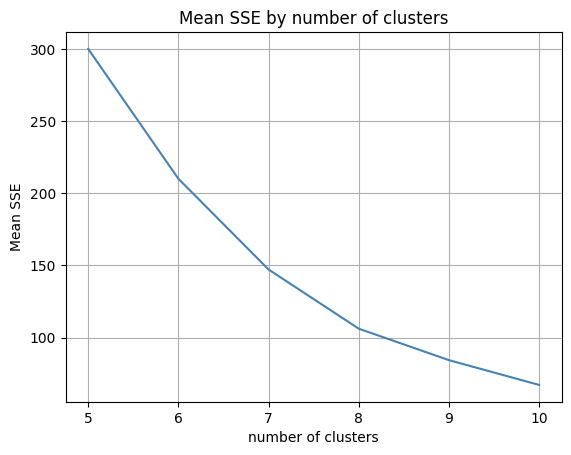

For n_clusters = 5 The average silhouette_score is : 0.3923503446334981
For n_clusters = 6 The average silhouette_score is : 0.36342863949239057
For n_clusters = 7 The average silhouette_score is : 0.40417417692913415
For n_clusters = 8 The average silhouette_score is : 0.40663540112055785
For n_clusters = 9 The average silhouette_score is : 0.39556057584262405
For n_clusters = 10 The average silhouette_score is : 0.3893268092518418


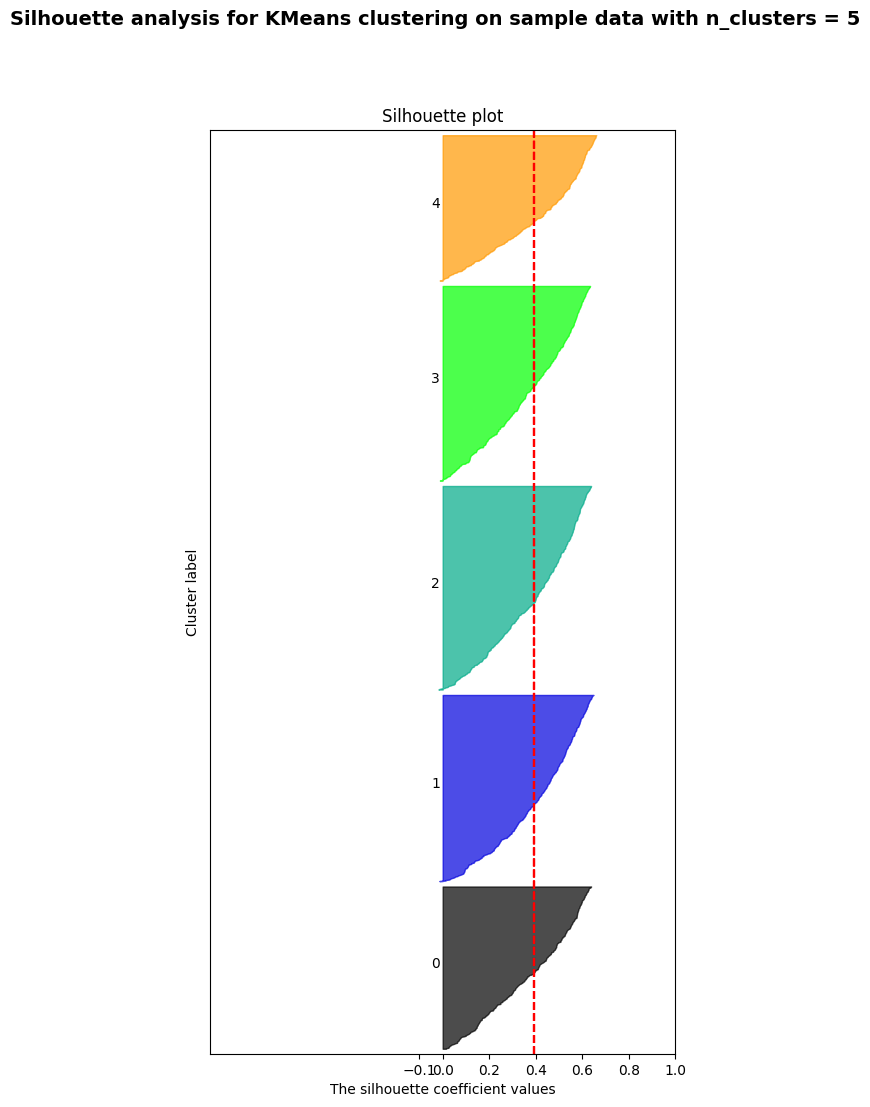

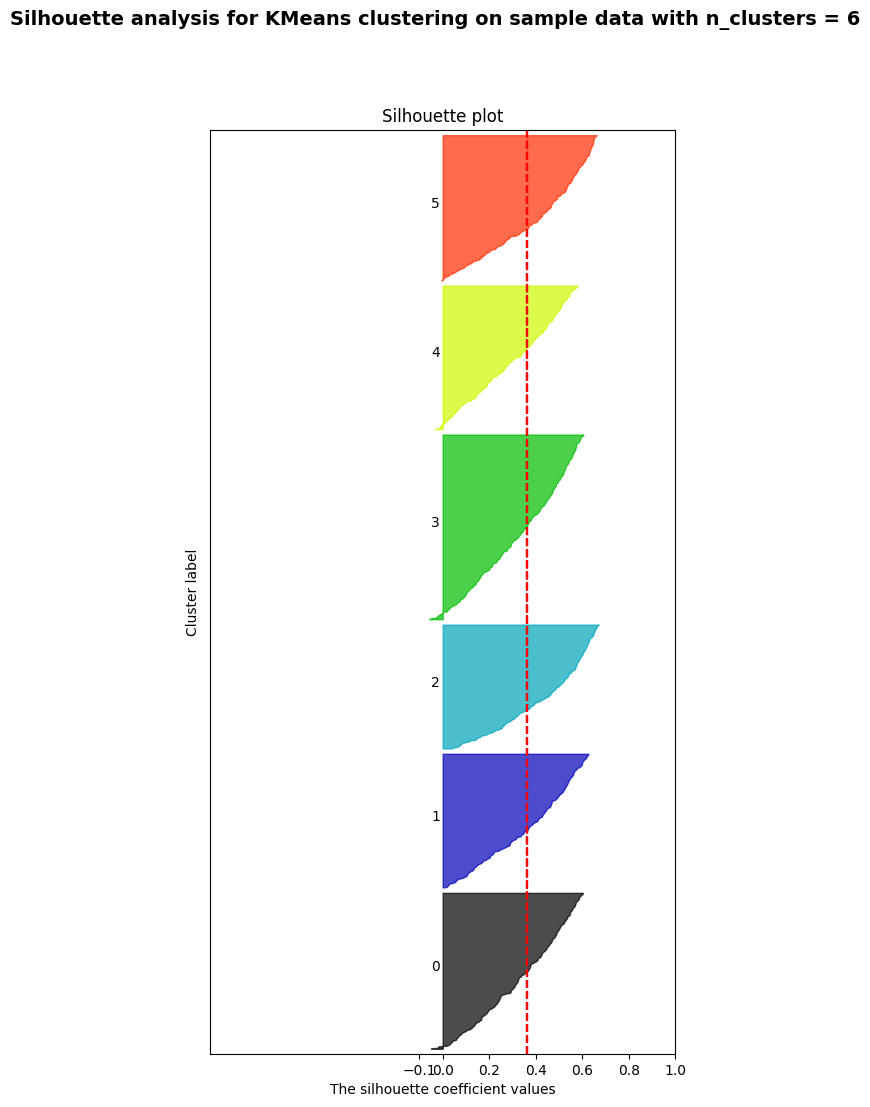

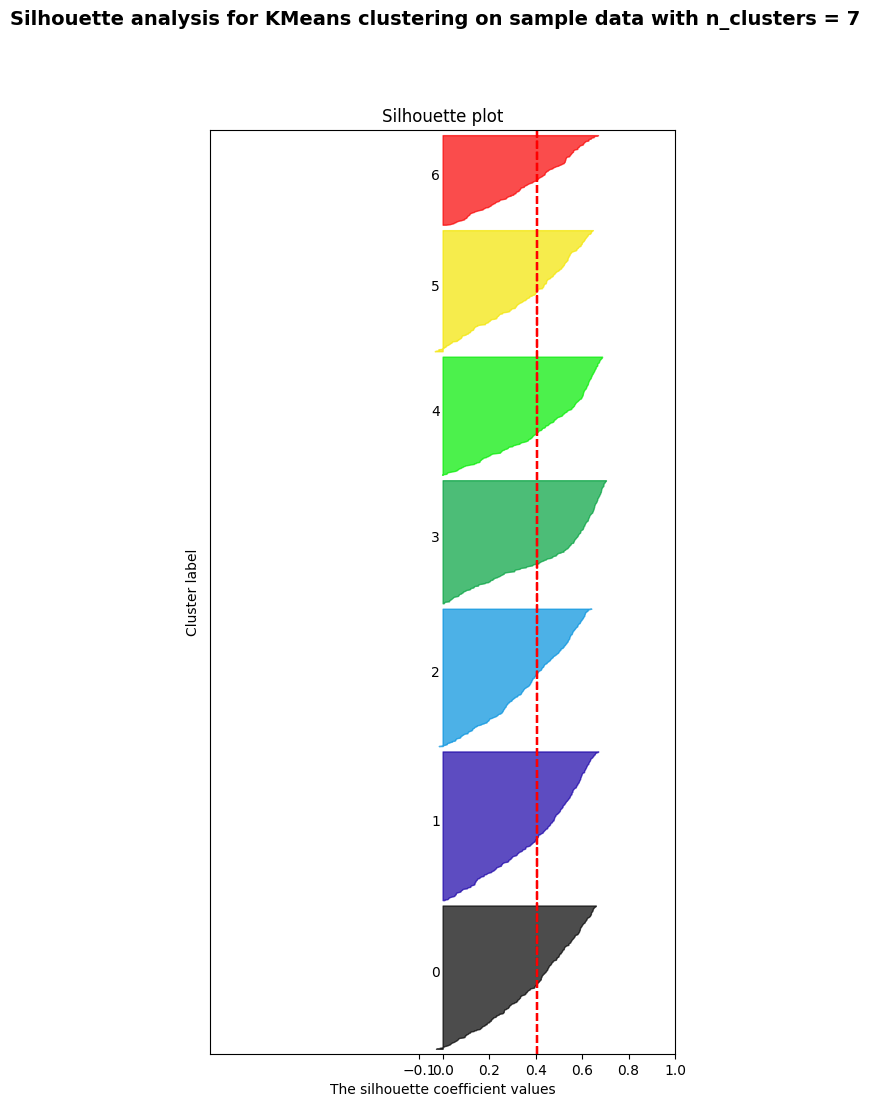

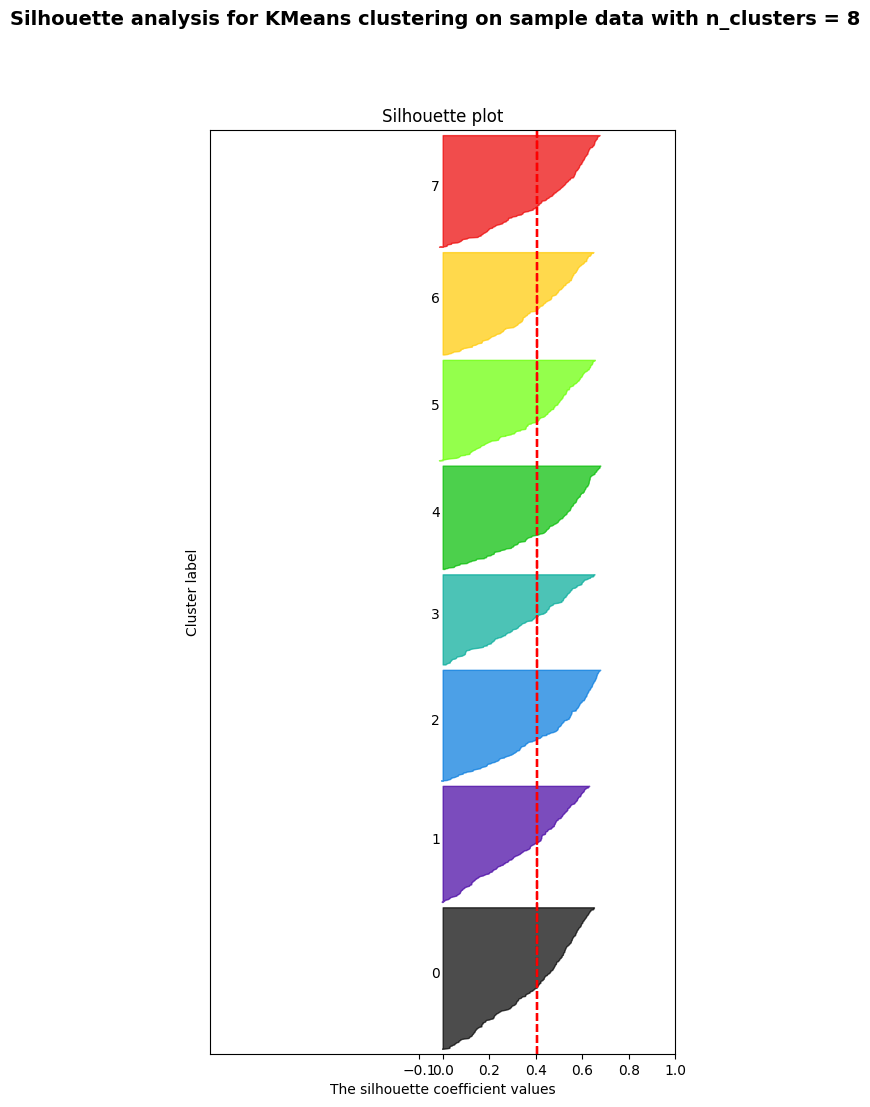

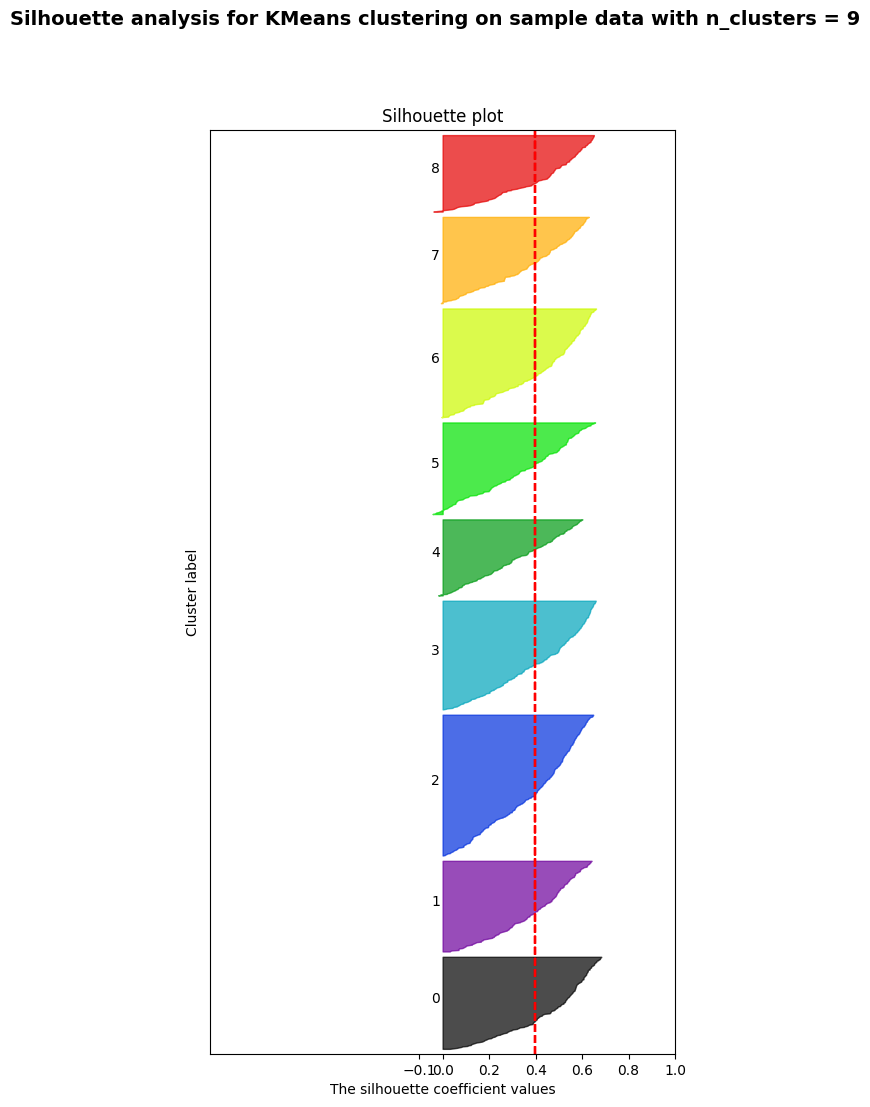

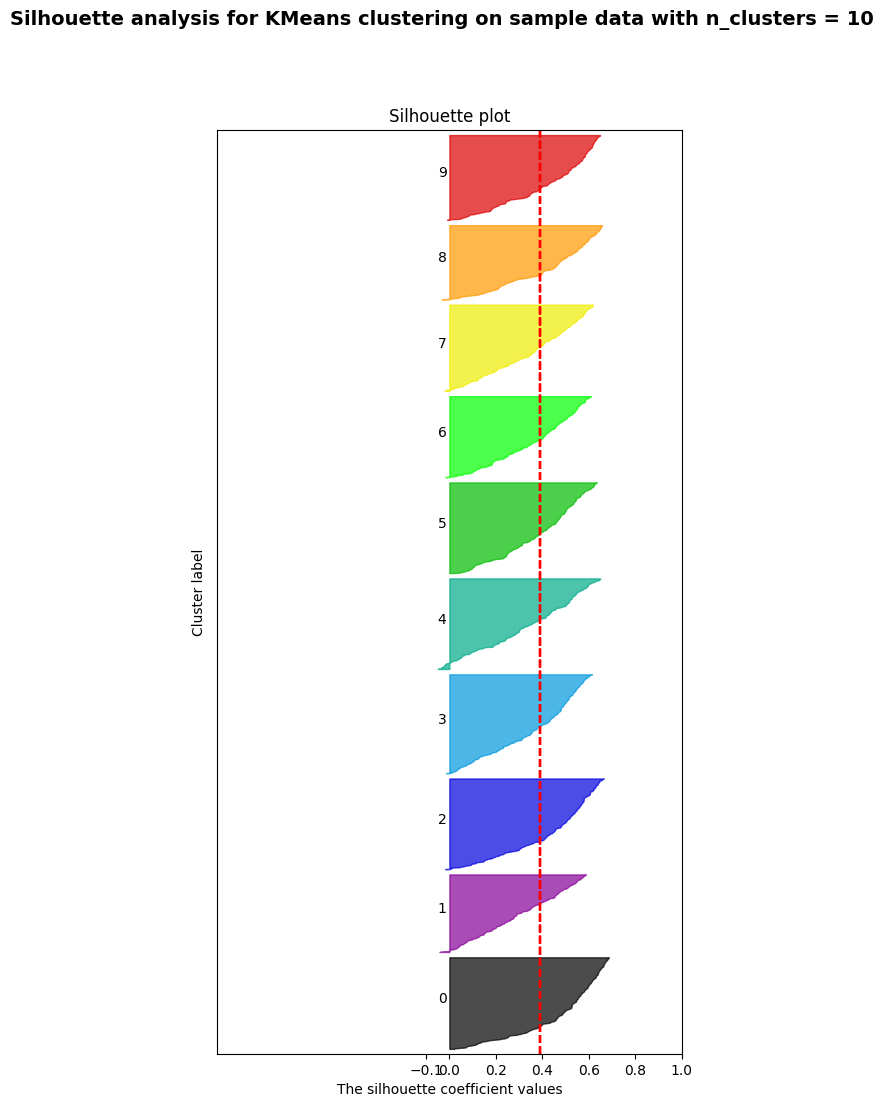

In [40]:
kmeans_mds = modelos_kmeans(k_values, projection_mds)
elbow_plot(k_values, projection_mds)
graficar_silluette(k_values, projection_mds)

EL gráfico ELBOW y el silluette promedio nos indica que es $k=8$ es el $k$ optimo. Esto se corrobora con el grafico el silluette, entonces elegimos el $k=8$. Buscamos el accuracy.

In [41]:
accuracy_score(
    y,KMeans(init='random', n_clusters=8,n_init=4).fit_predict(projection_mds)
)

0.07122982749026155

# Parte 4: Análisis (12 pts.)

Explique por qué el modelo de mejor desempeño supera en rendimiento a los demás ¿Qué es lo que le permite ganar?

Si medimos el desempeño con el accuracy, notamos que el PCA95 supera por mucho a sus alternativas. Esto es probablemente porque pierde menos informacion al simplificar los datos y el k óptimo es más cercano a 10, lo que hace que la calsificacion sea mejor y con más información para el ajuste. 

In [42]:
print('k = 7, PCA2: Acurracy = 0.04897050639955482, Silluette = 0.4032800129168165')
print('PCA 95, k = 9: Accuracy = 0.17807456872565386, Silluette =  0.20094137459546385')
print('TNSE, k = 9: Accuracy =  0.10127991096271564, Silluette = 0.5753224')
print('MDS, k = 8 Accuray = 0.07122982749026155, Silluette = 0.40663540112055785')

k = 7, PCA2: Acurracy = 0.04897050639955482, Silluette = 0.4032800129168165
PCA 95, k = 9: Accuracy = 0.17807456872565386, Silluette =  0.20094137459546385
TNSE, k = 9: Accuracy =  0.10127991096271564, Silluette = 0.5753224
MDS, k = 8 Accuray = 0.07122982749026155, Silluette = 0.40663540112055785
